After I loaded in the data I only did some basic cleaning, enough to start processing the data. 

* Changed the column names to a consistent capitalization.
* Changed Creation Date and Completion Date to datetime fields
* Deleted the columns containing "Dup", so we would only have unique requests
* Dropped the (2) rows in the dataframe which were almost completely NA, including Street Address
* Reset the index


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
url = 'https://data.cityofchicago.org/api/views/7as2-ds3y/rows.csv?accessType=DOWNLOAD'
df = pd.read_csv(url, sep=',', dtype={"Completion Date": object})
df.columns = ['Creation Date', 'Status', 'Completion Date', 'Service Request Number', 'Type of Service Request', 'Current Activity', 'Most Recent Action', 'Number of Potholes Filled on Block', 'Street Address', 'Zip', 'X Coordinate', 'Y Coordinate', 'Ward', 'Police District', 'Community Area', 'SSA', 'Latitude', 'Longitude', 'Location']
df['Creation Date'] =  pd.to_datetime(df['Creation Date'])
df['Completion Date'] =  pd.to_datetime(df['Completion Date'])
df = df[~df['Status'].str.contains("Dup")]
df = df.dropna(subset=['Street Address'])
df = df.reset_index(drop=True)
df.head().T


/home/anna/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4
Creation Date,2011-01-01 00:00:00,2011-01-01 00:00:00,2011-01-01 00:00:00,2011-01-01 00:00:00,2011-01-01 00:00:00
Status,Completed,Completed,Completed,Completed,Completed
Completion Date,2011-01-03 00:00:00,2011-01-03 00:00:00,2011-01-03 00:00:00,2011-01-03 00:00:00,2011-01-03 00:00:00
Service Request Number,11-00002021,11-00002273,11-00002650,11-00002654,11-00002656
Type of Service Request,Pot Hole in Street,Pot Hole in Street,Pot Hole in Street,Pot Hole in Street,Pot Hole in Street
Current Activity,Dispatch Crew,Dispatch Crew,Dispatch Crew,Dispatch Crew,Dispatch Crew
Most Recent Action,Pothole Patched,Pothole Patched,Pothole Patched,Pothole Patched,Pothole Patched
Number of Potholes Filled on Block,5,7,5,3,4
Street Address,1642 W 99TH ST,3500 S PULASKI RD,7851 S DR MARTIN LUTHER KING JR DR,15 E 79TH ST,359 E 79TH ST
Zip,60643,60623,60619,60619,60619


In [2]:
phc = df[df['Creation Date'].dt.year==2017]
phc = phc.dropna(subset=['Ward'])
phc = phc[phc['Ward']!=0]
phc = phc.groupby("Ward")["Number of Potholes Filled on Block"].count()
phc = phc.reset_index()
phc.columns=['Ward','Pothole Count']
phc.head()

,Ward,Pothole Count
0,1.0,706
1,2.0,865
2,3.0,628
3,4.0,623
4,5.0,849


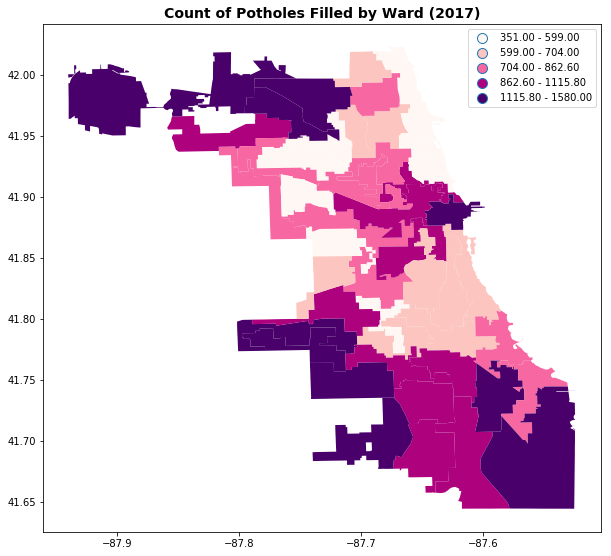

In [3]:
# read the shapefile as a GeoDataFrame
sf = gpd.GeoDataFrame.from_file("Downloads/497_Data/Wards/chiwards.shp")
sf['Ward'] = sf['ward'].astype(int)
response_map = pd.merge(sf,phc,on='Ward')
ax = response_map.plot(column='Pothole Count', scheme='quantiles', k=5, cmap='RdPu', legend=True, figsize=(10,20))
ax.set_title('Count of Potholes Filled by Ward (2017)', fontsize = 14, fontweight = 'bold')
plt.show()

In [4]:
wardpop = pd.read_csv("Downloads/497_Data/est_ward_pop.csv", skiprows = 1, skipfooter=1, thousands=',', engine='python')
cols = [0,9,10,11,12,13,14]
wardpop = wardpop[wardpop.columns[cols]]
wardpop.apply(pd.to_numeric)
wardpop.head()

,Ward,Total2016,White2016,Black2016,Asian2016,Latino2016,Other2016
0,1,56661,28550,3341,2091,21339,1341
1,2,57705,43108,3384,4002,5866,1345
2,3,55763,12602,33351,6234,2270,1308
3,4,57301,13849,34362,5233,2222,1635
4,5,52073,12333,32141,3870,2374,1354


In [5]:
pop_adj = pd.merge(phc, wardpop, right_on='Ward', left_on='Ward')
pop_adj['New'] = (pop_adj['Pothole Count'] / pop_adj['Total2016']) * 100
pop_adj.head()

,Ward,Pothole Count,Total2016,White2016,Black2016,Asian2016,Latino2016,Other2016,New
0,1.0,706,56661,28550,3341,2091,21339,1341,1.246007
1,2.0,865,57705,43108,3384,4002,5866,1345,1.499004
2,3.0,628,55763,12602,33351,6234,2270,1308,1.126195
3,4.0,623,57301,13849,34362,5233,2222,1635,1.087241
4,5.0,849,52073,12333,32141,3870,2374,1354,1.630403


In [6]:
url = "https://data.cityofchicago.org/api/views/pfsx-4n4m/rows.csv?accessType=DOWNLOAD"
df_traffic = pd.read_csv(url)
df_traffic.head()

,ID,Traffic Volume Count Location Address,Street,Date of Count,Total Passing Vehicle Volume,Vehicle Volume By Each Direction of Traffic,Latitude,Longitude,Location
0,2,1708 West,71st Street,03/09/2006,14600,East Bound: 6900 / West Bound: 7700,41.764877,-87.666635,"(41.764877, -87.666635)"
1,3,1275 West,71st Street,02/28/2006,16500,East Bound: 7800 / West Bound: 8700,41.765008,-87.657067,"(41.765008, -87.657067)"
2,5,920 West,71st Street,02/28/2006,18200,East Bound: 8800 / West Bound: 9400,41.765153,-87.647751,"(41.765153, -87.647751)"
3,6,758 West,71st Street,02/28/2006,21600,East Bound: 10400 / West Bound: 11200,41.765204,-87.644371,"(41.765204, -87.644371)"
4,7,240 East,71st St,02/28/2006,18300,East Bound: 9000 / West Bound: 9300,41.765644,-87.618476,"(41.765644, -87.618476)"


In [7]:
from shapely.geometry import Point, Polygon
geometry = [Point(xy) for xy in zip(df_traffic["Longitude"], df_traffic["Latitude"])]
geo_df = gpd.GeoDataFrame(df_traffic, geometry=geometry)
geo_df.head()

,ID,Traffic Volume Count Location Address,Street,Date of Count,Total Passing Vehicle Volume,Vehicle Volume By Each Direction of Traffic,Latitude,Longitude,Location,geometry
0,2,1708 West,71st Street,03/09/2006,14600,East Bound: 6900 / West Bound: 7700,41.764877,-87.666635,"(41.764877, -87.666635)",POINT (-87.666635 41.764877)
1,3,1275 West,71st Street,02/28/2006,16500,East Bound: 7800 / West Bound: 8700,41.765008,-87.657067,"(41.765008, -87.657067)",POINT (-87.657067 41.765008)
2,5,920 West,71st Street,02/28/2006,18200,East Bound: 8800 / West Bound: 9400,41.765153,-87.647751,"(41.765153, -87.647751)",POINT (-87.647751 41.76515300000001)
3,6,758 West,71st Street,02/28/2006,21600,East Bound: 10400 / West Bound: 11200,41.765204,-87.644371,"(41.765204, -87.644371)",POINT (-87.64437099999999 41.765204)
4,7,240 East,71st St,02/28/2006,18300,East Bound: 9000 / West Bound: 9300,41.765644,-87.618476,"(41.765644, -87.618476)",POINT (-87.618476 41.765644)


In [8]:
geo_df.crs = sf.crs
zips = gpd.sjoin(sf, geo_df, op='contains')
zips['Date of Count'] = pd.to_datetime(zips['Date of Count'])
zips['Date of Count'].dt.year
zips.head(3)

,shape_area,shape_leng,ward,geometry,Ward,index_right,ID,Traffic Volume Count Location Address,Street,Date of Count,Total Passing Vehicle Volume,Vehicle Volume By Each Direction of Traffic,Latitude,Longitude,Location
0,1.160965e+08,93073.340838,12,POLYGON ((-87.69623470134458 41.85755495238389...,12,1079,1166,2550 West,31st St,2006-10-11,14900,East Bound: 7000 / West Bound: 7900,41.838156,-87.689438,"(41.838156, -87.689438)"
0,1.160965e+08,93073.340838,12,POLYGON ((-87.69623470134458 41.85755495238389...,12,397,431,2703 West,Cermak Rd,2006-09-14,14200,East Bound: 7600 / West Bound: 6600,41.851933,-87.693114,"(41.851933, -87.693114)"
0,1.160965e+08,93073.340838,12,POLYGON ((-87.69623470134458 41.85755495238389...,12,571,614,2149 South,California Ave,2006-08-15,17700,North Bound: 8800 / South Bound: 8900,41.852259,-87.695456,"(41.852259, -87.695456)"


In [9]:
zips = zips.groupby(['Ward']).agg({
    'Total Passing Vehicle Volume': 'mean',
})

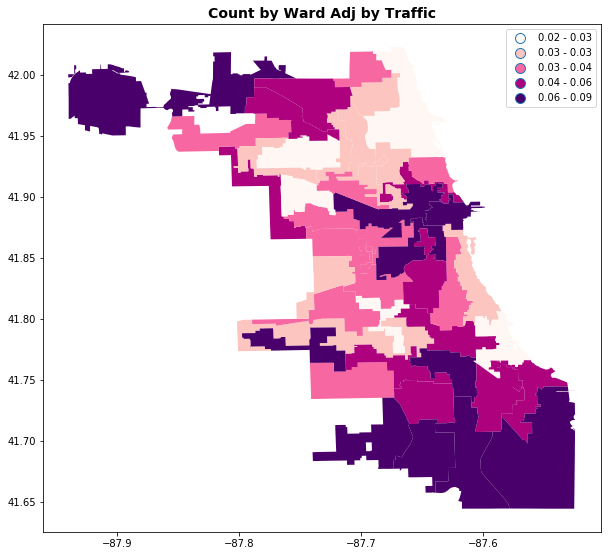

In [10]:
pop_adj = pd.merge(phc, zips, right_on='Ward', left_on='Ward')
pop_adj['New'] = (pop_adj['Pothole Count'] / pop_adj['Total Passing Vehicle Volume']) 
pop_adj.head(10)
response_map2 = pd.merge(sf,pop_adj,on='Ward')
ax2 = response_map2.plot(column='New', scheme='quantiles', k=5, cmap='RdPu', legend=True, figsize=(10,20))
ax2.set_title('Count by Ward Adj by Traffic', fontsize = 14, fontweight = 'bold')
plt.show()

The obvious trend for pothole formation would be seasonality. More potholes will be formed at the end of winter and spring, due to weather and thawing. I would like to confirm this basic trend with the data, so I set a mask of exactly a year from December 2017 to December 2018, assign a month column and plot service request count based on month. 

I group my data by (the beginning of the) month, summing up the number of potholes filled on the block. 

In [11]:
df_month = df[['Creation Date', 'Number of Potholes Filled on Block']].copy()
df_month = df_month.groupby(pd.Grouper(key='Creation Date', freq='1MS')).sum()
df_month = df_month.reset_index()

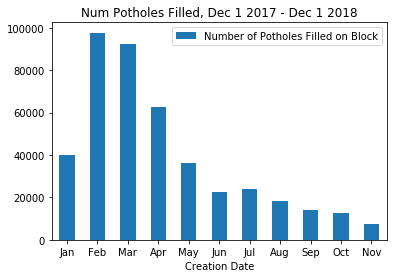

In [12]:
mask = (df_month['Creation Date'] > '2017-12-01') & (df_month['Creation Date'] < '2018-12-01')
df_2017 = df_month.loc[mask]
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b')
ax = df_2017.plot.bar(x='Creation Date', y='Number of Potholes Filled on Block')
ax.set_xticklabels(df_2017['Creation Date'].dt.strftime('%b'))
plt.xticks(rotation=0)
ax.set_title("Num Potholes Filled, Dec 1 2017 - Dec 1 2018")
plt.show()

Next I want to examine the relationship between snowfall and pothole formation (as done in the NYC Pothole Analysis). So I load in my snowfall data - since NOAA was only returning me empty sets when requesting snowfall data, I compiled this data myself from the weather.gov Chicago monthly snowfall records for December, January and February (https://www.weather.gov/lot/Chicago_Dec_Snow_Rankings) The reported 1.4 inches for 2018 December, since it was not on the website, comes from (https://wgntv.com/2019/02/13/was-december-2018-a-record-low-for-snow-in-chicago/)

In [13]:
dfs = pd.read_csv("Downloads/497_Data/snowfall_ohare.csv")
dfs['DATE'] = pd.to_datetime(dfs['DATE'])
dfs = dfs.groupby(pd.Grouper(key='DATE', freq='1MS')).agg({'SNOW': 'sum'})
dfs = dfs.reset_index()
dfs.head()

,DATE,SNOW
0,2010-01-01,9.1
1,2010-02-01,22.5
2,2010-03-01,1.8
3,2010-04-01,0.0
4,2010-05-01,0.0


Next I do an inner join on the months-potholes filled and snowfall data. 

In [15]:
df_sp = pd.concat([dfs.set_index('DATE'),df_month.set_index('Creation Date')], axis=1, join='inner')
df_sp = df_sp.reset_index()
df_sp.head()

,index,SNOW,Number of Potholes Filled on Block
0,2010-01-01,9.1,0.0
1,2010-02-01,22.5,0.0
2,2010-03-01,1.8,25.0
3,2010-04-01,0.0,7.0
4,2010-05-01,0.0,26.0


In [16]:
winter_mask = (df_sp['index'].map(lambda x: x.month) > 11) | (df_sp['index'].map(lambda x: x.month) < 3)
df_sp = df_sp[winter_mask]
df_sp.tail()

,index,SNOW,Number of Potholes Filled on Block
85,2017-02-01,0.0,60265.0
95,2017-12-01,5.3,15876.0
96,2018-01-01,4.6,40114.0
97,2018-02-01,20.3,97632.0
107,2018-12-01,1.4,3131.0


Scatterplot and regression line on snowfall vs. number of potholes filled on block, with an r<sup>2</sup> of .22. For comparison, the r<sup>2</sup> found in the NYC Pothole analysis for inches of snowfall was .31

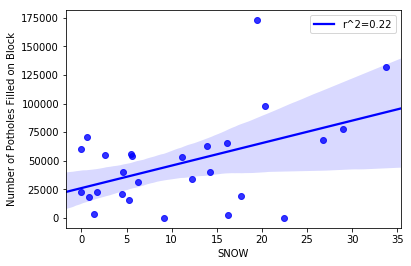

In [17]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df_sp['SNOW'],df_sp['Number of Potholes Filled on Block'])
ax = sns.regplot(x="SNOW", y="Number of Potholes Filled on Block", data=df_sp, color='b', line_kws={'label':"r^2={0:.2f}".format(r_value**2)})
ax.legend()
plt.show()

I needed to separate the Street Address field (which was all together, as in 1642 W 99TH ST) into Street Number, Direction, Name and Suffix. After having trouble getting the regexes to work, I came up with a somewhat hacky solution to do the splitting. I also want to standardize the street number to eventually join it with my street resurfacing data. Because the 311 data has # of potholes filled on block, +-100 in street address represents 1 block, I round down to the nearest 100 to get the pothole location by block. 

In [18]:
df_potholes = df.copy()
df_potholes['Street Number'] = df_potholes['Street Address'].str.split(' ').str[0]
df_potholes['Street Direction'] = df_potholes['Street Address'].str.split(' ').str[1]
df_potholes['Street Name'] = (df_potholes['Street Address'].str.split(' ').str[2:-1]).str.join(' ')
df_potholes['Street Suffix'] = df_potholes['Street Address'].str.split(' ').str[-1]
df_potholes['Adj Street Number'] = (((df_potholes['Street Number']).astype(int))//100)*100
df_potholes = df_potholes.drop(['Completion Date', 'Type of Service Request', 'Current Activity', 'Most Recent Action', 'Street Address'], axis=1)
df_potholes

,Creation Date,Status,Service Request Number,Number of Potholes Filled on Block,Zip,X Coordinate,Y Coordinate,Ward,Police District,Community Area,SSA,Latitude,Longitude,Location,Street Number,Street Direction,Street Name,Street Suffix,Adj Street Number
0,2011-01-01,Completed,11-00002021,5.0,60643.0,1.166945e+06,1.839061e+06,19.0,22.0,72.0,NaN,41.714035,-87.665096,"(41.71403466751051, -87.66509581640723)",1642,W,99TH,ST,1600
1,2011-01-01,Completed,11-00002273,7.0,60623.0,1.150258e+06,1.881340e+06,22.0,10.0,30.0,NaN,41.830224,-87.724352,"(41.830223541014355, -87.7243519544564)",3500,S,PULASKI,RD,3500
2,2011-01-01,Completed,11-00002650,5.0,60619.0,1.180265e+06,1.853038e+06,6.0,6.0,69.0,51.0,41.751434,-87.614820,"(41.75143385051753, -87.61481960290558)",7851,S,DR MARTIN LUTHER KING JR,DR,7800
3,2011-01-01,Completed,11-00002654,3.0,60619.0,1.177809e+06,1.852641e+06,6.0,6.0,44.0,NaN,41.750865,-87.623890,"(41.75086472111055, -87.62388985583482)",15,E,79TH,ST,0
4,2011-01-01,Completed,11-00002656,4.0,60619.0,1.179971e+06,1.852707e+06,6.0,6.0,44.0,51.0,41.750992,-87.615824,"(41.75099208108744, -87.61582439398472)",359,E,79TH,ST,300
5,2011-01-01,Completed,11-00002913,10.0,60621.0,1.177098e+06,1.856520e+06,6.0,7.0,69.0,NaN,41.761416,-87.626626,"(41.76141604711078, -87.62662592657588)",7312,S,LAFAYETTE,AVE,7300
6,2011-01-01,Completed,11-00002927,12.0,60619.0,1.177592e+06,1.854633e+06,6.0,6.0,69.0,NaN,41.756400,-87.624870,"(41.756400406672974, -87.62486968589552)",7600,S,STATE,ST,7600
7,2011-01-01,Completed,11-00003121,2.0,60611.0,1.179260e+06,1.905811e+06,42.0,18.0,8.0,NaN,41.896828,-87.617208,"(41.89682804500879, -87.61720770331104)",800,N,LAKE SHORE,DR,800
8,2011-01-01,Completed,11-00003356,32.0,60643.0,1.166627e+06,1.839052e+06,19.0,22.0,72.0,NaN,41.714022,-87.665222,"(41.71402220124287, -87.66522178348544)",9899,S,VANDERPOEL,AVE,9800
9,2011-01-01,Completed,11-00003428,2.0,60621.0,1.177080e+06,1.857263e+06,6.0,7.0,69.0,NaN,41.763574,-87.626669,"(41.76357428849735, -87.62666940365537)",7200,S,LAFAYETTE,AVE,7200


Next, I summed up the number of potholes filled on block per adjusted street number. For visualization purposes, since geocoding each new address would be expensive, I took the first latitude/longitude from the sorted dataframe of real addresses before grouping to correspond to our adjusted addresses. 

In [19]:
df4 = (df_potholes.loc[df_potholes['Ward']==19.0]).copy()
df4 = df4.sort_values(['Street Number', 'Street Name', 'Street Direction'])
df4 = df4.groupby(['Adj Street Number', 'Street Direction', 'Street Name', 'Street Suffix']).agg({
    'Location': 'first',
    'Number of Potholes Filled on Block': 'sum'
})
df4 = df4.reset_index()
df4.head()

,Adj Street Number,Street Direction,Street Name,Street Suffix,Location,Number of Potholes Filled on Block
0,1400,W,103RD,ST,"(41.70685308300817, -87.65887406317246)",20.0
1,1400,W,104TH,ST,"(41.70483067408288, -87.65804188583073)",153.0
2,1400,W,105TH,PL,"(41.70233848003942, -87.65782062916087)",36.0
3,1400,W,105TH,ST,"(41.70323704708031, -87.65749604582594)",0.0
4,1400,W,107TH,ST,"(41.69931652153758, -87.66011505209809)",1.0


Converted the lat/long string to a tuple, and then to a Point, flipping it into long/lat. 

In [20]:
import ast
df4["Location"] = df4["Location"].apply(lambda x: ast.literal_eval(x))
df4.head()

,Adj Street Number,Street Direction,Street Name,Street Suffix,Location,Number of Potholes Filled on Block
0,1400,W,103RD,ST,"(41.70685308300817, -87.65887406317246)",20.0
1,1400,W,104TH,ST,"(41.70483067408288, -87.65804188583073)",153.0
2,1400,W,105TH,PL,"(41.70233848003942, -87.65782062916087)",36.0
3,1400,W,105TH,ST,"(41.70323704708031, -87.65749604582594)",0.0
4,1400,W,107TH,ST,"(41.69931652153758, -87.66011505209809)",1.0


In [21]:
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
df4["Location"] = df4.apply(lambda x: Point(x["Location"][1], x["Location"][0]) , axis = 1)
df4.head()

,Adj Street Number,Street Direction,Street Name,Street Suffix,Location,Number of Potholes Filled on Block
0,1400,W,103RD,ST,POINT (-87.65887406317246 41.70685308300817),20.0
1,1400,W,104TH,ST,POINT (-87.65804188583073 41.70483067408288),153.0
2,1400,W,105TH,PL,POINT (-87.65782062916087 41.70233848003942),36.0
3,1400,W,105TH,ST,POINT (-87.65749604582594 41.70323704708031),0.0
4,1400,W,107TH,ST,POINT (-87.66011505209809 41.69931652153758),1.0


Scaled the # of potholes filled on block by a percentage of total potholes filled

In [22]:
tot1 = df4['Number of Potholes Filled on Block'].sum()
df4['Percentage'] = df4['Number of Potholes Filled on Block'].apply(lambda x: (x/tot1)*100)
df4.describe()

,Adj Street Number,Number of Potholes Filled on Block,Percentage
count,1156.000000,1156.000000,1156.000000
mean,7310.467128,145.879758,0.086505
std,3950.435709,176.802642,0.104842
min,1400.000000,0.000000,0.000000
25%,2600.000000,21.000000,0.012453
50%,9700.000000,79.000000,0.046846
75%,10700.000000,209.000000,0.123935
max,11800.000000,1523.000000,0.903123


Created a function to a apply a scaling number based on each percentage value - this is for the visualization

In [23]:
def alert(c):
  if c["Number of Potholes Filled on Block"] <=0.012453:
    return .5
  elif c["Percentage"] >=0.50:
    return 200.0
  elif c["Percentage"] >=0.223935:
    return 50.0
  else:
    return 1
df4['Scale'] = df4.apply(alert, axis=1)
df4.head()

,Adj Street Number,Street Direction,Street Name,Street Suffix,Location,Number of Potholes Filled on Block,Percentage,Scale
0,1400,W,103RD,ST,POINT (-87.65887406317246 41.70685308300817),20.0,0.011860,1.0
1,1400,W,104TH,ST,POINT (-87.65804188583073 41.70483067408288),153.0,0.090727,1.0
2,1400,W,105TH,PL,POINT (-87.65782062916087 41.70233848003942),36.0,0.021348,1.0
3,1400,W,105TH,ST,POINT (-87.65749604582594 41.70323704708031),0.0,0.000000,0.5
4,1400,W,107TH,ST,POINT (-87.66011505209809 41.69931652153758),1.0,0.000593,1.0


In [24]:
# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)


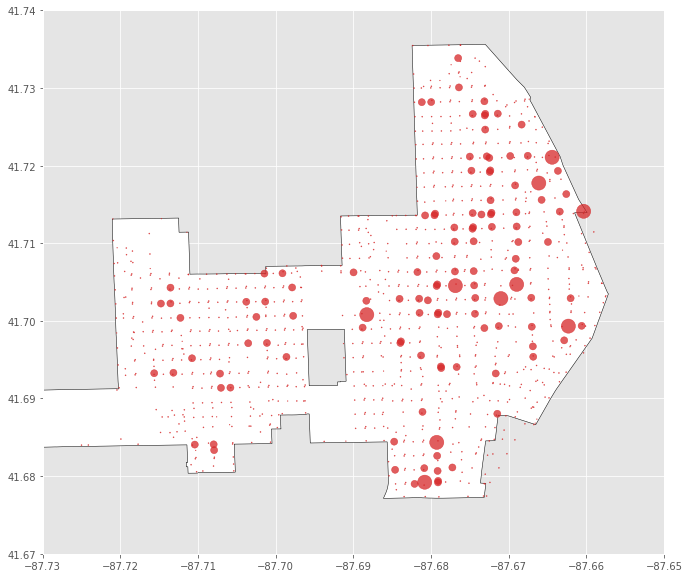

In [25]:
plt.style.use('ggplot')
gdf = gpd.GeoDataFrame(df4, geometry='Location')
g1 = gpd.read_file("Downloads/497_Data/Wards/chiwards.shp")
ward_19 = g1[g1['ward'] == '19'] 
ax = ward_19.plot(color='white', edgecolor='black', figsize=(20,10))
ax = gdf.plot(ax=ax, c=[tableau20[6]], alpha=0.75, markersize=df4['Scale'])
plt.xlim([-87.73, -87.65])
plt.ylim([41.67, 41.74])  
plt.show() 

Used this tutorial to generate the map: 
https://automating-gis-processes.github.io/2018/notebooks/L5/interactive-map-folium.html

In [28]:
import mplleaflet
mplleaflet.display(fig=ax.figure, crs=gdf.crs)

/home/anna/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Next I load in my street moratorium data (which I am using to approximate street resurface dates). I change the start and end dates to pandas datetime

In [29]:
df_mora = pd.read_csv("Downloads/497_Data/moratoriums.csv")
df_mora = df_mora[df_mora["MORATORIUM TYPE"] == "Street Resurfacing"]
df_mora['START DATE'] = pd.to_datetime(df_mora['START DATE'], format='%m/%d/%Y')
df_mora['EXPIRATION DATE'] = pd.to_datetime(df_mora['EXPIRATION DATE'], format='%m/%d/%Y')

86% of the data was 5 year gaps, which makes sense given the CDOT description, but the next highest frequency of (expiration date - start date) (.8%) was 0 year, some rows having only a 10 day gap between start and expiry, which made no sense. Because I had no idea how to interpret that, in the end I weighed that only keeping the 5-year differences data would be better than keeping data I had no idea actually represented resurface date. Also dropped duplicates.

In [30]:
df_mora['SME'] = df_mora['EXPIRATION DATE'].dt.year - df_mora['START DATE'].dt.year
df_mora = df_mora[df_mora['SME']==5] # SME = start minus expire
df_mora = df_mora.drop_duplicates()

The median of the resurface range was 95.0 and the mean 141 (difference in street address numbers). I take this to mean that the average resurface range is about a block. 

In [31]:
df_mora.describe()

,STREET ADDRESS BEGIN,STREET ADDRESS END,SME
count,10618.000000,10618.000000,10618.0
mean,3936.679224,4077.689019,5.0
std,2958.794364,2961.904842,0.0
min,0.000000,4.000000,5.0
25%,1600.000000,1702.000000,5.0
50%,3301.000000,3459.000000,5.0
75%,5800.000000,5960.500000,5.0
max,13336.000000,13629.000000,5.0


<b>TODO:</b>
Number of potholes by length of time since resurfacing OR resurfacing gap